In [1]:
import sys

sys.path.append('../')

import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.gridspec import GridSpec
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torch.fft import fft2, fftshift, ifft2, ifftshift
from tqdm import tqdm

from models.das import DelayAndSum
from models.deconv import MultiChannelDeconv, WienerBatched
from models.pact import SOS2Wavefront, Wavefront2TF
from utils.dataio import *
from utils.reconstruction import get_coordinates
from utils.simulations import *
from utils.utils_torch import crop_half, get_fourier_coord
from utils.visualization import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_DIR = '../data/'
RESULTS_DIR = '../results_new/numerical/'

### Load data

In [2]:
IP_gt = load_mat(os.path.join(DATA_DIR, 'IP.mat'))
IP_gt = standardize(IP_gt)
SOS_gt = load_mat(os.path.join(DATA_DIR, 'SOS_easy.mat'))
data_range_IP = 13 # IP_gt.max() - IP_gt.min()

sinogram_uniform = load_mat(os.path.join(DATA_DIR, 'sinogram_simulation_uniform.mat'))
sinogram = load_mat(os.path.join(DATA_DIR, 'sinogram_simulation_easy.mat'))
sinogram += np.random.normal(0, 1e-4, sinogram.shape)

### Preparations

In [3]:
Nx, Ny = 560, 560
dx, dy = 4e-5, 4e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
x_vec, y_vec = kgrid.x_vec, kgrid.y_vec
l = 3.2e-3 # Patch size [m].

Define parameters of the single-body SOS.

In [4]:
R = 9.8e-3              # Radius of single body [m].
T = 26.0                # Water temperature [C].
v0 = get_water_sos(T)   # Background SOS [m/s].

Pick the small patch in the intil pressure image.

In [5]:
i, j = 18, 15
x, y, r, phi = get_coordinates(i, j, l)
# x, y = (j-12)*l / 4, (12-i)*l / 4
k2D, theta2D = get_fourier_coord(N=80, l=l, device='cpu')
print(x, y, r*1e3, phi)

0.0024000000000000002 -0.0048000000000000004 5.366563145999496 2.677945044588987


Define the delays for reconstruction and the elays for visualization, which is a subset of the former.

In [6]:
delays = np.arange(-8e-4, 8e-4, 5e-5)
ids_show = [12, 16, 20, 24, 28]
delays_show = delays[ids_show]
print(delays_show)

[-2.00000000e-04  3.25260652e-19  2.00000000e-04  4.00000000e-04
  6.00000000e-04]


### Conventional DAS

In [7]:
das = DelayAndSum(R_ring=0.05, N_transducer=512, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, mode='zero')
das.cuda()
das.eval()

DelayAndSum()

In [8]:
with torch.no_grad():
    rec_das = das(sinogram=torch.tensor(sinogram, device=device),
                  v0=1508.7,
                  d_delay=torch.zeros(1, device=device),
                  ring_error=torch.zeros(1, device=device)).detach().cpu().numpy()

In [9]:
rec_das = rec_das[20*i:20*i+80, 20*j:20*j+80]

### Single Body

In [10]:
sos2wf = SOS2Wavefront(R, v0, x_vec, y_vec, n_thetas=180)
sos2wf.cuda()
sos2wf.eval()
wf2tf = Wavefront2TF(N=160, l=6.4e-3, n_delays=delays.shape[0])
wf2tf.cuda()
wf2tf.eval()
deconv = MultiChannelDeconv()
deconv.cuda()
deconv.eval()

MultiChannelDeconv()

In [11]:
img_stack = []
with torch.no_grad():
    for d_delay in tqdm(delays, desc='DAS'):
        recon = das(sinogram=torch.tensor(sinogram).cuda(), 
                    v0=torch.tensor(v0).cuda(),
                    d_delay=torch.tensor(d_delay).cuda(),
                    ring_error=torch.zeros(1).cuda())
        img_stack.append(recon)
img_stack = torch.stack(img_stack, dim=0)

DAS: 100%|██████████| 32/32 [00:02<00:00, 10.96it/s]


In [12]:
gt = IP_gt[20*i:20*i+80, 20*j:20*j+80].copy()
thetas, wfs = sos2wf(torch.tensor([x]).cuda(), torch.tensor([y]).cuda(), torch.tensor(SOS_gt).cuda())
tf_stack = wf2tf(torch.tensor(delays).cuda().view(1,-1,1,1), thetas, wfs)
obs_stack = img_stack[...,20*i:20*i+80, 20*j:20*j+80].unsqueeze(0)
# obs_stack = img_stack[...,20*i-40:20*i+120, 20*j-40:20*j+120].unsqueeze(0)
rec_combined, _, _ = deconv(obs_stack, tf_stack)
rec_combined = rec_combined.squeeze(0).squeeze(0).detach().cpu().numpy()

In [13]:
recs = []
deconv = WienerBatched(lam=10e-3, order=0.5)
deconv.cuda()
deconv.eval()
for idx, delay in zip(ids_show, delays_show):
    tf = tf_stack[:,idx:idx+1,:,:]
    obs = obs_stack[:,idx:idx+1,:,:]
    rec = deconv(obs, tf)
    rec = rec.squeeze(0).squeeze(0).detach().cpu().numpy()
    recs.append(rec)

In [14]:
recs = [standardize(img) for img in recs]
[rec_das, rec_combined, gt] = [standardize(img) for img in [rec_das, rec_combined, gt]]
data_range_patch = rec_das.max() - rec_das.min()

In [15]:
rs = [0, R/4, r, 0.77*R, R]
psfs_show, tfs_show = [], []
for r in rs:
    x, y = r*np.sin(phi), r*np.cos(phi)
    print(x, y)
    thetas, wfs = sos2wf(torch.tensor([x]).cuda(), torch.tensor([y]).cuda(), torch.tensor(SOS_gt).cuda())
    tf = wf2tf(torch.tensor(delays).cuda().view(1,-1,1,1), thetas, wfs).squeeze(0).detach().cpu()
    tf = tf[ids_show,...]
    psf = crop_half(fftshift((ifft2(tf)), dim=(-2,-1)).real)
    psf /= psf.sum(dim=(-2,-1)).unsqueeze(-1).unsqueeze(-1)
    psfs_show.append(psf)
    tfs_show.append(tf)
psfs_show, tfs_show = torch.stack(psfs_show, dim=0), torch.stack(tfs_show, dim=0)
print(psfs_show.shape)

0.0 -0.0
0.0010956733089748972 -0.0021913466179497936
0.002400000000000001 -0.0048000000000000004
0.0033746737916426836 -0.006749347583285365
0.004382693235899589 -0.008765386471799174
torch.Size([5, 5, 80, 80])


In [16]:
best_ids = [3,3,3,2,1]
n_delays_list = [4, 8, 16, 32]

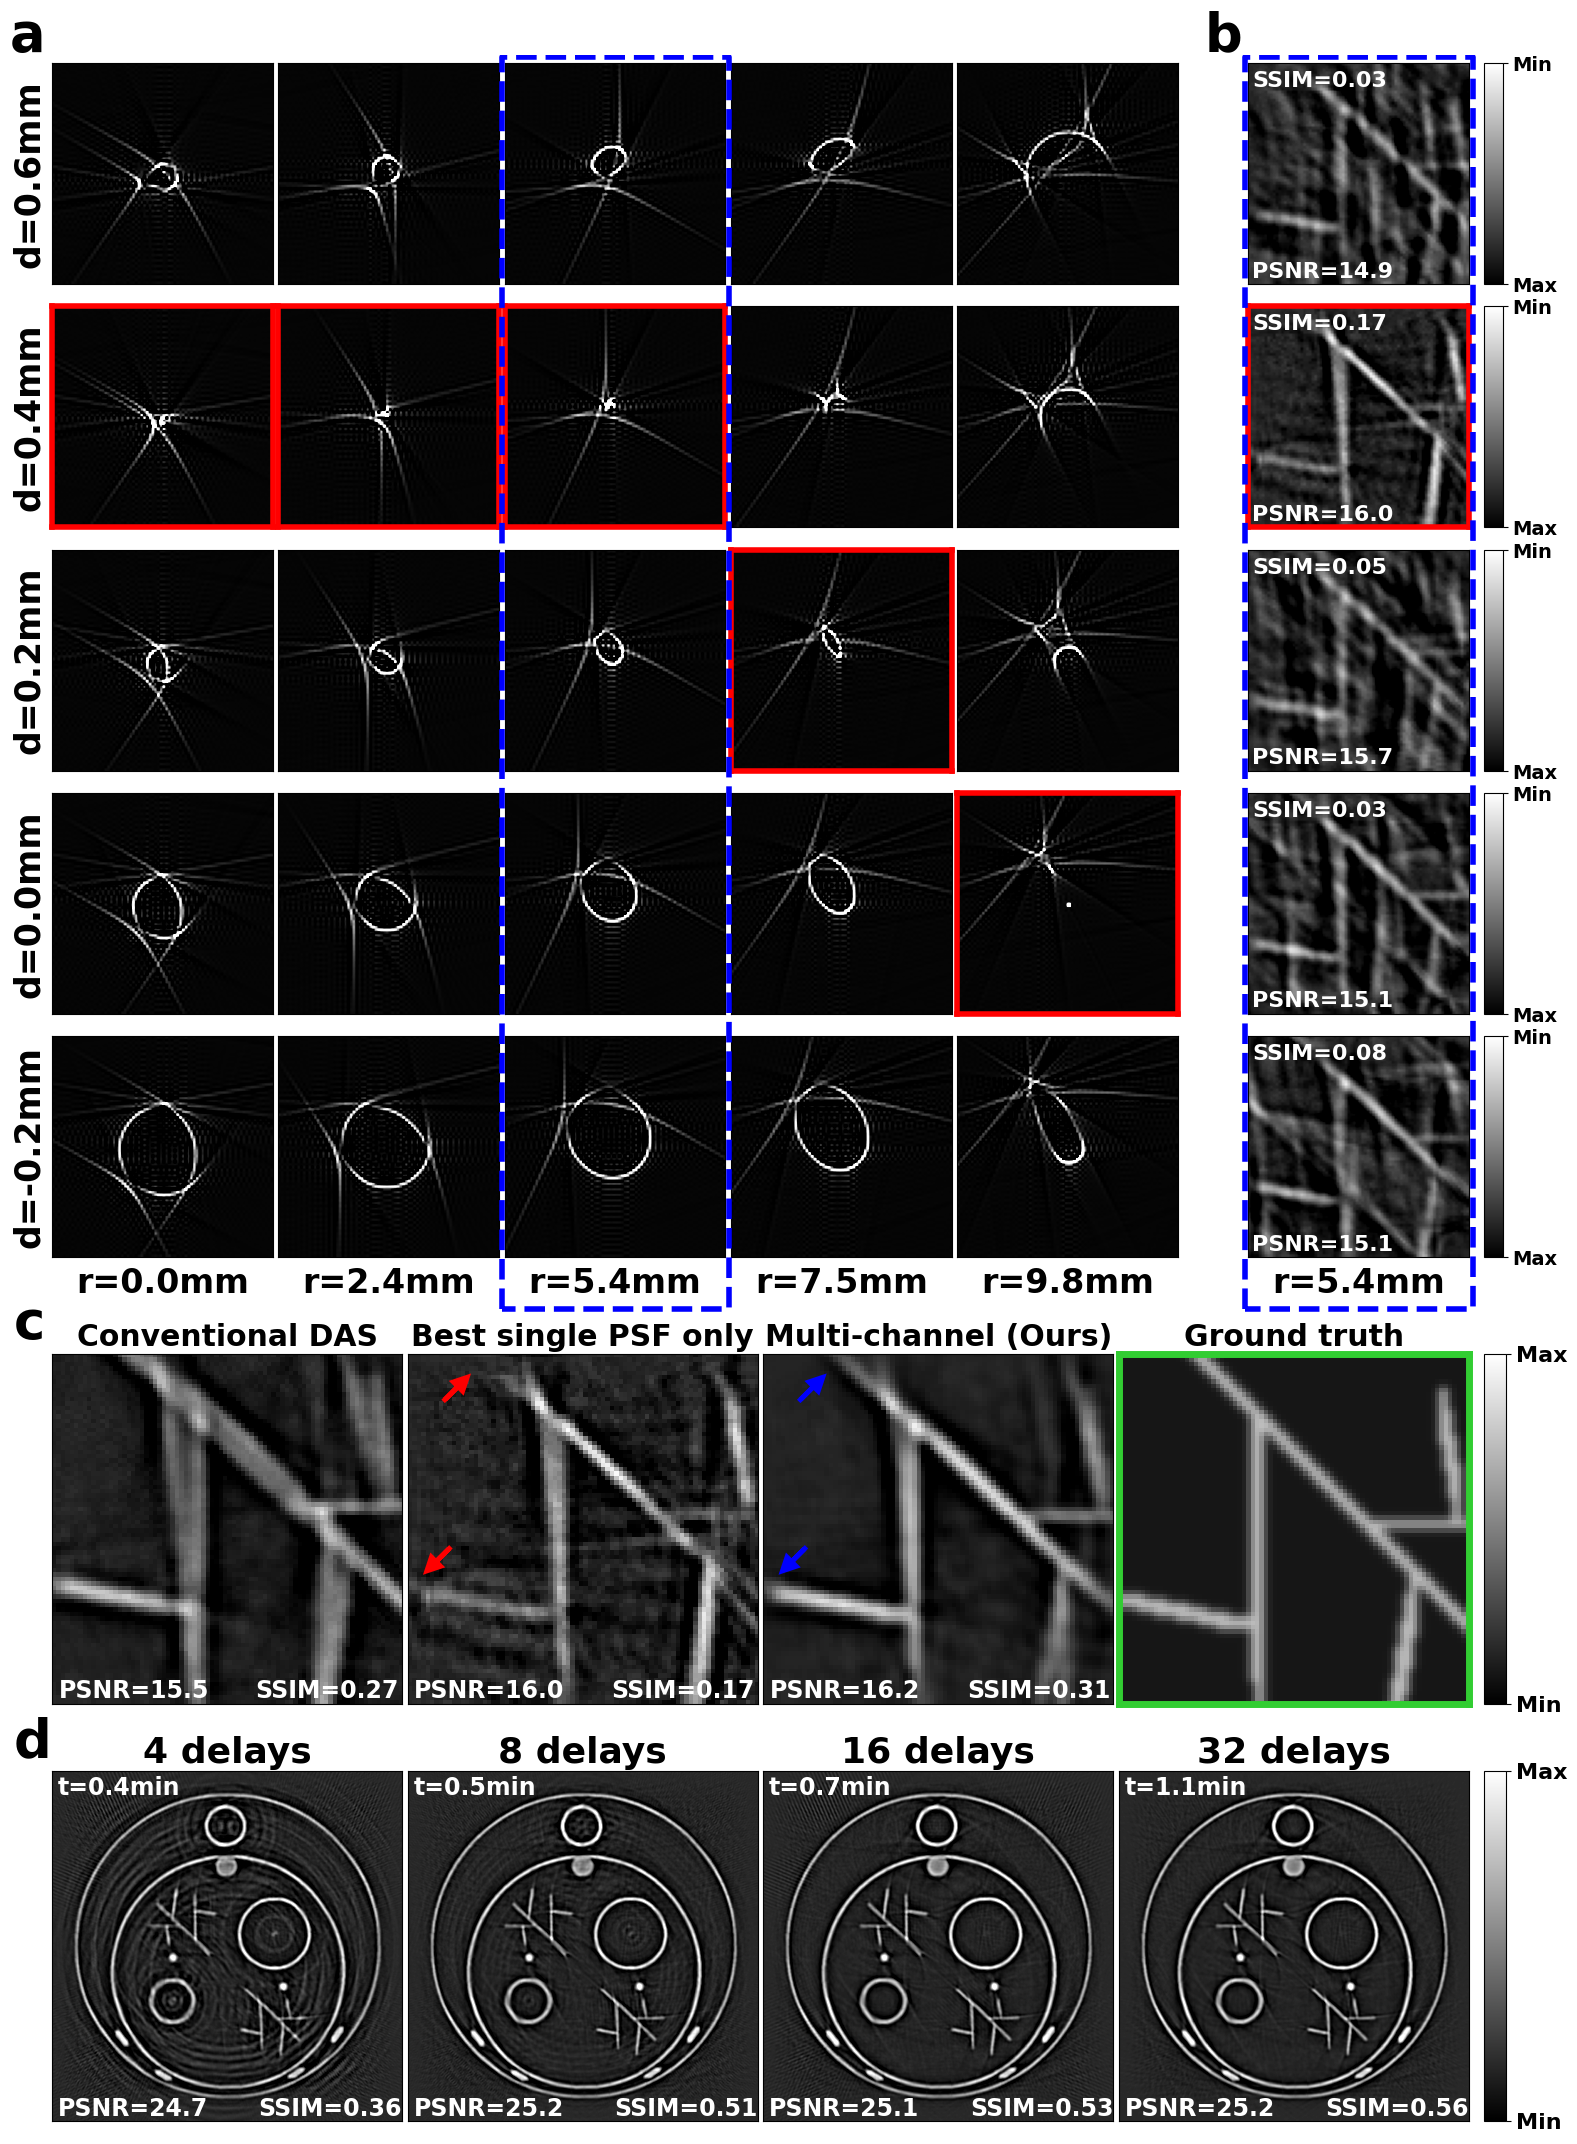

: 

In [17]:
fig, main_ax = plt.subplots(figsize=(18.7, 27))
gs = GridSpec(60, 45)
norm_IP = Normalize(vmax=5, vmin=-1)
norm_psf = Normalize(vmin=-1e-3, vmax=0.05)
# Panel a: PSF stacks at different locations.
for i, r_i in enumerate(rs):
    for j, delay in enumerate(delays_show):
        ax = plt.subplot(gs[28-7*j:35-7*j,7*i:7*(i+1)])
        plt.imshow(psfs_show[i,j], cmap='gray', norm=norm_psf)
        plt.xticks([])
        plt.yticks([])
        # plt.title('$\kappa$={:.1f}'.format(condition_number(tfs_show[i,j])), fontsize=13, loc='left', y=0.0, x=0.03, color='white')
        if i == 0:
            plt.ylabel('d={:.1f}mm'.format(delays_show[j]*1e3), fontsize=25, fontweight='bold')
            if j == 4:
                plt.title('a', loc='center', x=-0.11, y=1.02, fontsize=38, fontweight='bold', color='black')
        # elif i == 4:
        #     cax = fig.add_axes([ax.get_position().x1+0.008, ax.get_position().y0, 0.01, ax.get_position().height])
        #     cb = plt.colorbar(cax=cax)
            # cb.set_ticks([3e-4, 0.04])
            # cb.set_ticklabels(['Min', 'Max'], fontsize=13.5)
        if j == 0:
            ax.set_title('r={:.1f}mm'.format(r_i*1e3), fontsize=24, fontweight='bold', y=-0.2)
        elif j == best_ids[i]:
            for loc in ['bottom', 'top', 'left', 'right']:
                ax.spines[loc].set_color('red')
                ax.spines[loc].set_linewidth(4)

# Panel b: comparing different delays in single-channel deconvolution.
for j, delay in enumerate(delays_show):
    ax = plt.subplot(gs[7*(4-j):7*(5-j),37:44])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(recs[j], cmap='gray', norm=norm_IP)
    plt.text(s='PSNR={:.1f}'.format(psnr(gt, recs[j], data_range=data_range_patch)), x=1, y=77, fontsize=16, fontweight='bold', color='white')
    plt.text(s='SSIM={:.2f}'.format(ssim(gt, recs[j], data_range=data_range_patch)), x=1, y=8, fontsize=16, fontweight='bold', color='white')
    if j == 0:
        ax.set_title('r={:.1f}mm'.format(rs[2]*1e3), fontsize=24, fontweight='bold', y=-0.2)  
    elif j == 4:
        plt.title('b', loc='center', x=-0.11, y=1.02, fontsize=38, fontweight='bold', color='black')
    elif j == best_ids[2]:
        for loc in ['bottom', 'top', 'left', 'right']:
            ax.spines[loc].set_color('red')
            ax.spines[loc].set_linewidth(4)
         
    cax = fig.add_axes([ax.get_position().x1+0.008, ax.get_position().y0, 0.01, ax.get_position().height])
    cb = plt.colorbar(cax=cax, norm=norm_IP)
    cb.set_ticks([5, -1])
    cb.set_ticklabels(['Min', 'Max'], fontsize=14, fontweight='bold')

main_ax.set_zorder(20)
main_ax.axis('off')
main_ax.set_xlim(0, 45)
main_ax.set_ylim(0, 60)
y1, y2 = 23.8, 59.95
x1, x2 = 13.97, 21.02
x3, x4 = 37.04, 44.11
main_ax.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], color='blue', linewidth=4., linestyle='--')
main_ax.plot([x3, x3, x4, x4, x3], [y1, y2, y2, y1, y1], color='blue', linewidth=4., linestyle='--')

# Panel c: comparing single/multi-channel deconvolution on an image patch.
for j, (img, title) in enumerate(zip([rec_das, recs[best_ids[2]], rec_combined, gt], ['Conventional DAS', 'Best single PSF only', 'Multi-channel (Ours)', 'Ground truth'])):
    ax = plt.subplot(gs[37:48,11*j:11*(j+1)])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray', norm=norm_IP)
    plt.title(title, fontsize=21.5, fontweight='bold')
    if j < 3:
        plt.text(s='PSNR={:.1f}'.format(psnr(gt, img, data_range=data_range_patch)), x=1, y=78, fontsize=17, fontweight='bold', color='white')
        plt.text(s='SSIM={:.2f}'.format(ssim(gt, img, data_range=data_range_patch)), x=46, y=78, fontsize=17, fontweight='bold', color='white')
    if j == 0:
        plt.title('c', loc='left', x=-0.11, y=1.02, fontsize=38, fontweight='bold', color='black')
    elif j == 1:
        plt.arrow(8, 10, 3, -3, color='red', linewidth=3.5, head_width=3, head_length=3)
        plt.arrow(9, 44, -3, 3, color='red', linewidth=3.5, head_width=3, head_length=3)
    elif j == 2:
        plt.arrow(8, 10, 3, -3, color='blue', linewidth=3.5, head_width=3, head_length=3)
        plt.arrow(9, 44, -3, 3, color='blue', linewidth=3.5, head_width=3, head_length=3)
    elif j == 3:
        for loc in ['bottom', 'top', 'left', 'right']:
            ax.spines[loc].set_color('limegreen')
            ax.spines[loc].set_linewidth(5)
        cax = fig.add_axes([ax.get_position().x1+0.008, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax)
        cb.set_ticks([-1, 5])
        cb.set_ticklabels(['Min', 'Max'], fontsize=16, fontweight='bold')

# Panel d: comparing different number of delays in mutli-channel deconvolution.
for j, n_delays in enumerate(n_delays_list):
    params = '{}delays_{}lyrs_{}fts_TV={:.1e}_{}epochs_bs={}_lr={:.1e}'.format(n_delays, 1, 64, 5e-5, 10, 64, 1e-3)
    IP_rec = standardize(load_mat(os.path.join(RESULTS_DIR, 'NF-APACT', params, 'IP_rec.mat')))
    t = load_log(os.path.join(RESULTS_DIR, 'NF-APACT', params, 'log.json'))['time']
    ax = plt.subplot(gs[49:60,11*j:11*(j+1)])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(IP_rec, cmap='gray', norm=norm_IP)
    plt.title(f'{n_delays} delays', fontsize=26, fontweight='bold')
    plt.text(s='PSNR={:.1f}'.format(psnr(IP_gt, IP_rec, data_range=data_range_IP)), x=9, y=551, fontsize=17, fontweight='bold', color='white')
    plt.text(s='SSIM={:.2f}'.format(ssim(IP_gt, IP_rec, data_range=data_range_IP)), x=330, y=551, fontsize=17, fontweight='bold', color='white')
    plt.text(s='t={:.1f}min'.format(t/60), x=9, y=38, fontsize=17, fontweight='bold', color='white')
    if j == 0:
        plt.title('d', loc='left', x=-0.11, y=1.015, fontsize=38, fontweight='bold', color='black')
    elif j == 3:
        cax = fig.add_axes([ax.get_position().x1+0.008, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax)
        cb.set_ticks([-1, 5])
        cb.set_ticklabels(['Min', 'Max'], fontsize=16, fontweight='bold')

plt.savefig('figure_deconvolution.png', dpi=256, bbox_inches='tight')